# NPAE-Var-GNB

Using device: cuda
Epoch [10/200], Loss: 0.0977
Epoch [20/200], Loss: 0.0726
Epoch [30/200], Loss: 0.0657
Epoch [40/200], Loss: 0.0686
Epoch [50/200], Loss: 0.0475
Epoch [60/200], Loss: 0.0437
Epoch [70/200], Loss: 0.0464
Epoch [80/200], Loss: 0.0509
Epoch [90/200], Loss: 0.0496
Epoch [100/200], Loss: 0.0375
Epoch [110/200], Loss: 0.0376
Epoch [120/200], Loss: 0.0472
Epoch [130/200], Loss: 0.0353
Epoch [140/200], Loss: 0.0385
Epoch [150/200], Loss: 0.0418
Epoch [160/200], Loss: 0.0376
Epoch [170/200], Loss: 0.0388
Epoch [180/200], Loss: 0.0361
Epoch [190/200], Loss: 0.0439
Epoch [200/200], Loss: 0.0405
Epoch [10/500], Loss: 1.1831, Feature Loss: 1.5914, Adj Loss: 0.7748
Epoch [20/500], Loss: 0.7607, Feature Loss: 0.9240, Adj Loss: 0.5975
Epoch [30/500], Loss: 0.5797, Feature Loss: 0.6500, Adj Loss: 0.5093
Epoch [40/500], Loss: 0.5069, Feature Loss: 0.5288, Adj Loss: 0.4851
Epoch [50/500], Loss: 0.4426, Feature Loss: 0.4555, Adj Loss: 0.4296
Epoch [60/500], Loss: 0.3996, Feature Loss: 0

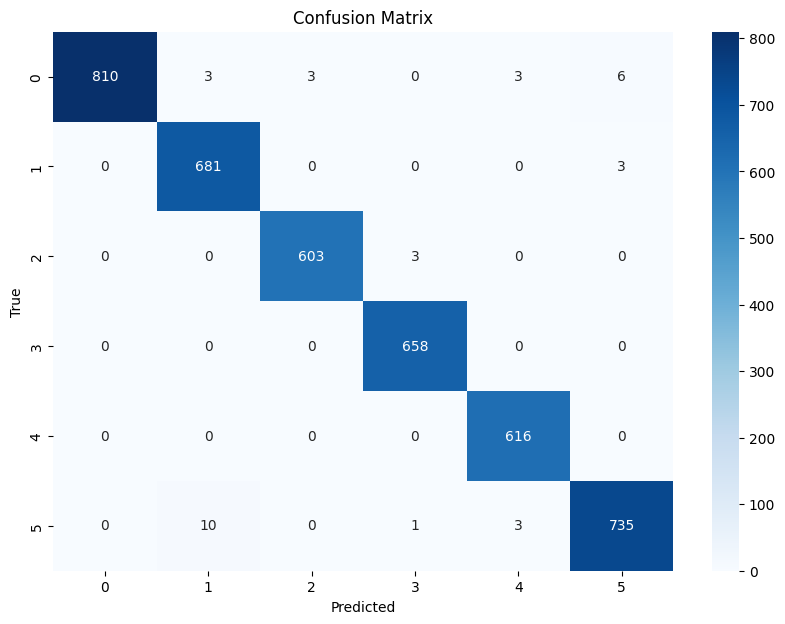

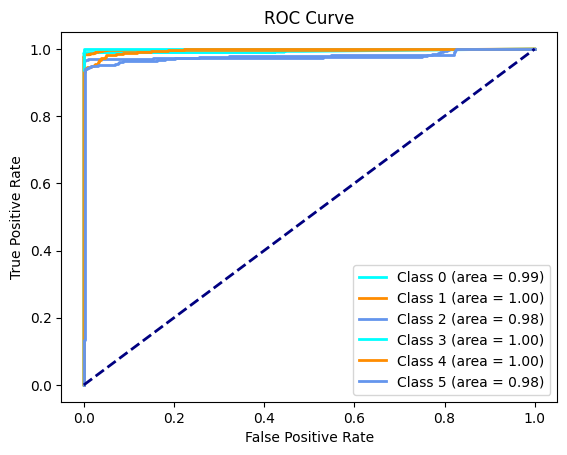

Average Accuracy: 0.9915
Class 0 - Average Precision: 1.0000, Average Recall: 0.9817, Average F1-Score: 0.9907
Class 1 - Average Precision: 0.9813, Average Recall: 0.9957, Average F1-Score: 0.9884
Class 2 - Average Precision: 0.9949, Average Recall: 0.9946, Average F1-Score: 0.9948
Class 3 - Average Precision: 0.9941, Average Recall: 1.0000, Average F1-Score: 0.9970
Class 4 - Average Precision: 0.9906, Average Recall: 1.0000, Average F1-Score: 0.9952
Class 5 - Average Precision: 0.9874, Average Recall: 0.9809, Average F1-Score: 0.9841


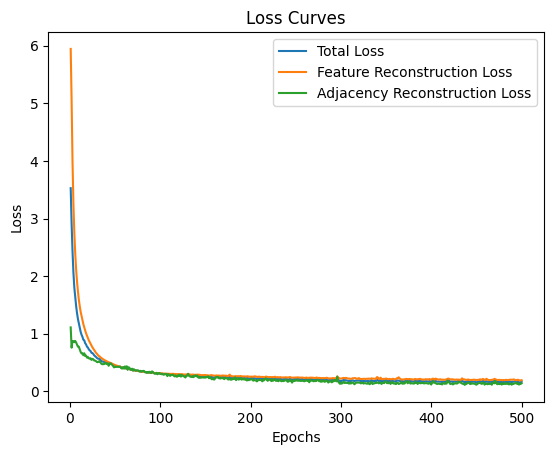

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
num_classes = len(np.unique(all_labels.cpu().numpy()))
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32
k_folds = 5

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft = torch.utils.data.DataLoader(list(zip(features_tensor, all_labels)), batch_size=batch_size_ft, shuffle=True)

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    total_loss_list.append(running_loss / len(train_loader_ft.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features = feature_transformer.encoder(features_tensor).detach().cpu().numpy()

class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_means = {}
        self.feature_variances = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = X_c.shape[0] / X.shape[0]
            self.feature_means[c] = np.mean(X_c, axis=0)
            self.feature_variances[c] = np.var(X_c, axis=0)

    def predict(self, X):
        posteriors = []
        for x in X:
            posteriors.append(self._calculate_posteriors(x))
        return np.array([max(p, key=p.get) for p in posteriors])

    def predict_proba(self, X):
        probabilities = []
        for x in X:
            posteriors = self._calculate_posteriors(x)
            probabilities.append({c: np.exp(posteriors[c]) for c in self.classes})
        return probabilities

    def _calculate_posteriors(self, x):
        posteriors = {}
        for c in self.classes:
            prior = np.log(self.class_priors[c])
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.feature_variances[c]))
            likelihood -= 0.5 * np.sum(((x - self.feature_means[c]) ** 2) / (self.feature_variances[c]))
            posteriors[c] = prior + likelihood
        return posteriors

kf = KFold(n_splits=k_folds)
accuracy_list = []
precision_list = [[] for _ in range(num_classes)]
recall_list = [[] for _ in range(num_classes)]
f1_list = [[] for _ in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

y_test_all = []
y_pred_all = []
y_pred_prob_all = []

for train_index, test_index in kf.split(new_features):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = all_labels[train_index].cpu().numpy(), all_labels[test_index].cpu().numpy()
    
    nb_classifier = NaiveBayesClassifier()
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    y_pred_prob = nb_classifier.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    accuracy_list.append(accuracy)
    for i in range(num_classes):
        precision_list[i].append(report[str(i)]['precision'])
        recall_list[i].append(report[str(i)]['recall'])
        f1_list[i].append(report[str(i)]['f1-score'])
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

y_test_bin = label_binarize(y_test_all, classes=np.unique(all_labels.cpu().numpy()))
y_pred_prob_bin = np.zeros_like(y_test_bin, dtype=float)
for i, probs in enumerate(y_pred_prob_all):
    for j, c in enumerate(nb_classifier.classes):
        y_pred_prob_bin[i, j] = probs[c]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
sns.heatmap(np.round(conf_matrix).astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels.cpu().numpy()), yticklabels=np.unique(all_labels.cpu().numpy()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f'Average Accuracy: {np.mean(accuracy_list):.4f}')
for i in range(num_classes):
    print(f'Class {i} - Average Precision: {np.mean(precision_list[i]):.4f}, '
          f'Average Recall: {np.mean(recall_list[i]):.4f}, '
          f'Average F1-Score: {np.mean(f1_list[i]):.4f}')

# Plot the loss curves
plt.figure()
plt.plot(range(1, num_epochs_ft + 1), total_loss_list, label='Total Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_loss_list, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), adj_loss_list, label='Adjacency Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# NPAE-Cov-GNB

Using device: cuda
Epoch [10/200], Loss: 0.0909
Epoch [20/200], Loss: 0.0565
Epoch [30/200], Loss: 0.0575
Epoch [40/200], Loss: 0.0480
Epoch [50/200], Loss: 0.0529
Epoch [60/200], Loss: 0.0490
Epoch [70/200], Loss: 0.0448
Epoch [80/200], Loss: 0.0466
Epoch [90/200], Loss: 0.0395
Epoch [100/200], Loss: 0.0419
Epoch [110/200], Loss: 0.0432
Epoch [120/200], Loss: 0.0398
Epoch [130/200], Loss: 0.0391
Epoch [140/200], Loss: 0.0390
Epoch [150/200], Loss: 0.0343
Epoch [160/200], Loss: 0.0378
Epoch [170/200], Loss: 0.0422
Epoch [180/200], Loss: 0.0335
Epoch [190/200], Loss: 0.0349
Epoch [200/200], Loss: 0.0371
Epoch [10/500], Loss: 0.4887, Feature Loss: 0.4887, Adj Loss: 58.0403
Epoch [20/500], Loss: 0.1270, Feature Loss: 0.1270, Adj Loss: 57.5293
Epoch [30/500], Loss: 0.0828, Feature Loss: 0.0828, Adj Loss: 51.9819
Epoch [40/500], Loss: 0.0549, Feature Loss: 0.0549, Adj Loss: 48.5569
Epoch [50/500], Loss: 0.0285, Feature Loss: 0.0285, Adj Loss: 46.7864
Epoch [60/500], Loss: 0.0289, Feature Lo

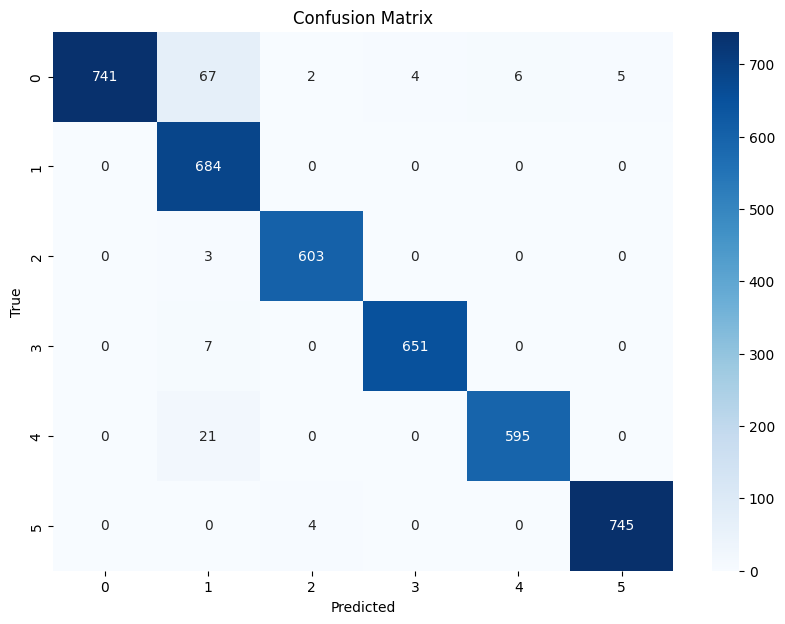

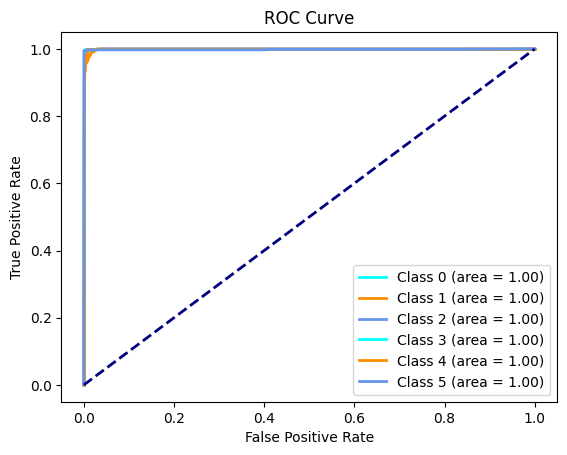

Average Accuracy: 0.9712
Class 0 - Average Precision: 1.0000, Average Recall: 0.8978, Average F1-Score: 0.9459
Class 1 - Average Precision: 0.8753, Average Recall: 1.0000, Average F1-Score: 0.9334
Class 2 - Average Precision: 0.9897, Average Recall: 0.9946, Average F1-Score: 0.9921
Class 3 - Average Precision: 0.9941, Average Recall: 0.9895, Average F1-Score: 0.9918
Class 4 - Average Precision: 0.9898, Average Recall: 0.9661, Average F1-Score: 0.9776
Class 5 - Average Precision: 0.9931, Average Recall: 0.9946, Average F1-Score: 0.9938


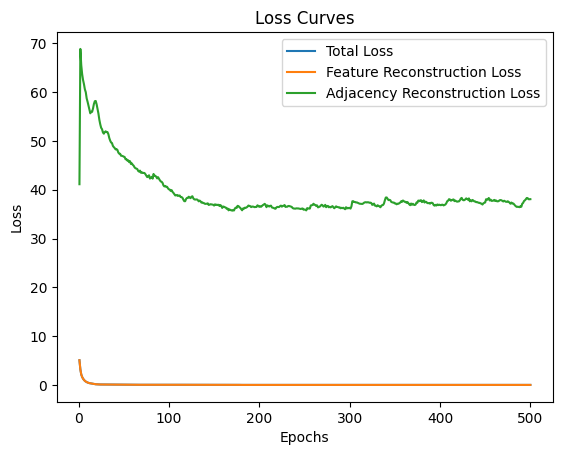

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
num_classes = len(np.unique(all_labels.cpu().numpy()))
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32
k_folds = 5

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=1.0):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft = torch.utils.data.DataLoader(list(zip(features_tensor, all_labels)), batch_size=batch_size_ft, shuffle=True)

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

# Lists to store losses for plotting
total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    # Record the losses for plotting
    total_loss_list.append(running_loss / len(train_loader_ft.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features = feature_transformer.encoder(features_tensor).detach().cpu().numpy()

class CustomGaussianNB:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_prior_ = np.array([np.mean(y == c) for c in self.classes])
        self.theta_ = np.array([X[y == c].mean(axis=0) for c in self.classes])
        
        self.class_covariances_ = []
        for i in range(len(self.classes)):
            class_i_indices = np.where(y == self.classes[i])[0]
            cov_matrix = np.cov(X[class_i_indices], rowvar=False)
            # Ensure the covariance matrix is positive definite
            cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
            self.class_covariances_.append(cov_matrix)
    
    def predict(self, X):
        joint_log_likelihood = []
        for i in range(len(self.classes)):
            inv_cov = np.linalg.inv(self.class_covariances_[i])
            diff = X - self.theta_[i]
            term1 = np.sum(np.dot(diff, inv_cov) * diff, axis=1)
            term2 = np.log(np.linalg.det(self.class_covariances_[i]))
            jointi = np.log(self.class_prior_[i]) - 0.5 * (term1 + term2)
            joint_log_likelihood.append(jointi)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        return self.classes[np.argmax(joint_log_likelihood, axis=1)]
    
    def predict_proba(self, X):
        joint_log_likelihood = []
        for i in range(len(self.classes)):
            inv_cov = np.linalg.inv(self.class_covariances_[i])
            diff = X - self.theta_[i]
            term1 = np.sum(np.dot(diff, inv_cov) * diff, axis=1)
            term2 = np.log(np.linalg.det(self.class_covariances_[i]))
            jointi = np.log(self.class_prior_[i]) - 0.5 * (term1 + term2)
            joint_log_likelihood.append(jointi)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        
        log_prob_x = np.log(np.sum(np.exp(joint_log_likelihood - np.max(joint_log_likelihood, axis=1, keepdims=True)), axis=1))
        return np.exp(joint_log_likelihood - log_prob_x[:, np.newaxis] - np.max(joint_log_likelihood, axis=1, keepdims=True))

kf = KFold(n_splits=k_folds)
accuracy_list = []
precision_list = [[] for _ in range(num_classes)]
recall_list = [[] for _ in range(num_classes)]
f1_list = [[] for _ in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

y_test_all = []
y_pred_all = []
y_pred_prob_all = []

for train_index, test_index in kf.split(new_features):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = all_labels[train_index].cpu().numpy(), all_labels[test_index].cpu().numpy()
    
    nb_classifier = CustomGaussianNB()
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    y_pred_prob = nb_classifier.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    accuracy_list.append(accuracy)
    for i in range(num_classes):
        precision_list[i].append(report[str(i)]['precision'])
        recall_list[i].append(report[str(i)]['recall'])
        f1_list[i].append(report[str(i)]['f1-score'])
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

y_test_bin = label_binarize(y_test_all, classes=np.unique(all_labels.cpu().numpy()))
y_pred_prob_bin = np.zeros_like(y_test_bin, dtype=float)
for i, probs in enumerate(y_pred_prob_all):
    for j, c in enumerate(nb_classifier.classes):
        y_pred_prob_bin[i, j] = probs[c]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
sns.heatmap(np.round(conf_matrix).astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels.cpu().numpy()), yticklabels=np.unique(all_labels.cpu().numpy()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f'Average Accuracy: {np.mean(accuracy_list):.4f}')
for i in range(num_classes):
    print(f'Class {i} - Average Precision: {np.mean(precision_list[i]):.4f}, '
          f'Average Recall: {np.mean(recall_list[i]):.4f}, '
          f'Average F1-Score: {np.mean(f1_list[i]):.4f}')

# Plot the loss curves
plt.figure()
plt.plot(range(1, num_epochs_ft + 1), total_loss_list, label='Total Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_loss_list, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), adj_loss_list, label='Adjacency Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# NPAE-SVM

Using device: cuda
Epoch [10/200], Loss: 0.0919
Epoch [20/200], Loss: 0.0766
Epoch [30/200], Loss: 0.0564
Epoch [40/200], Loss: 0.0539
Epoch [50/200], Loss: 0.0525
Epoch [60/200], Loss: 0.0442
Epoch [70/200], Loss: 0.0477
Epoch [80/200], Loss: 0.0377
Epoch [90/200], Loss: 0.0433
Epoch [100/200], Loss: 0.0398
Epoch [110/200], Loss: 0.0432
Epoch [120/200], Loss: 0.0379
Epoch [130/200], Loss: 0.0365
Epoch [140/200], Loss: 0.0433
Epoch [150/200], Loss: 0.0379
Epoch [160/200], Loss: 0.0393
Epoch [170/200], Loss: 0.0410
Epoch [180/200], Loss: 0.0333
Epoch [190/200], Loss: 0.0533
Epoch [200/200], Loss: 0.0400
Epoch [10/500], Loss: 0.3371, Feature Loss: 7.1119, Adj Loss: 0.3371
Epoch [20/500], Loss: 0.1934, Feature Loss: 8.0543, Adj Loss: 0.1934
Epoch [30/500], Loss: 0.0984, Feature Loss: 9.0695, Adj Loss: 0.0984
Epoch [40/500], Loss: 0.0880, Feature Loss: 10.0901, Adj Loss: 0.0880
Epoch [50/500], Loss: 0.0680, Feature Loss: 10.9168, Adj Loss: 0.0680
Epoch [60/500], Loss: 0.0560, Feature Loss:

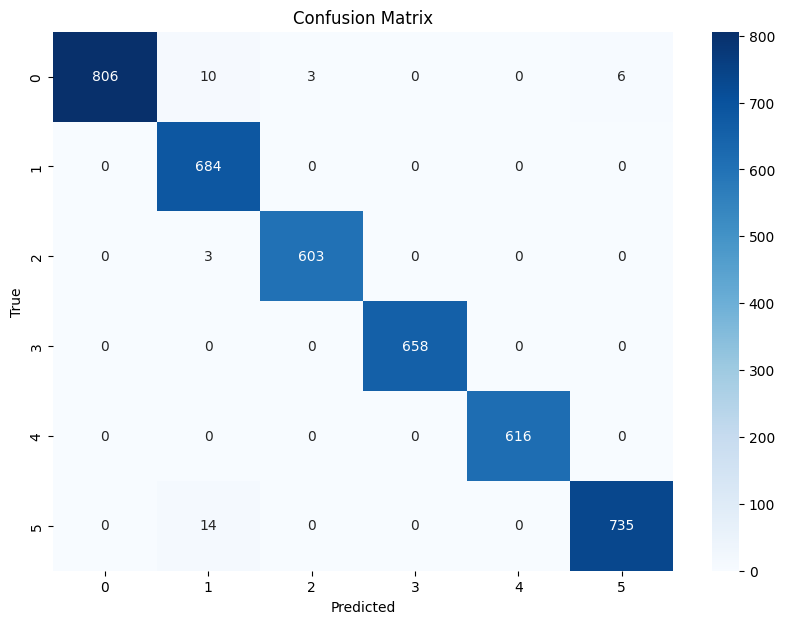

Average Accuracy: 0.9913
Class 0 - Average Precision: 1.0000, Average Recall: 0.9769, Average F1-Score: 0.9883
Class 1 - Average Precision: 0.9622, Average Recall: 1.0000, Average F1-Score: 0.9807
Class 2 - Average Precision: 0.9949, Average Recall: 0.9946, Average F1-Score: 0.9948
Class 3 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 4 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 5 - Average Precision: 0.9915, Average Recall: 0.9809, Average F1-Score: 0.9862


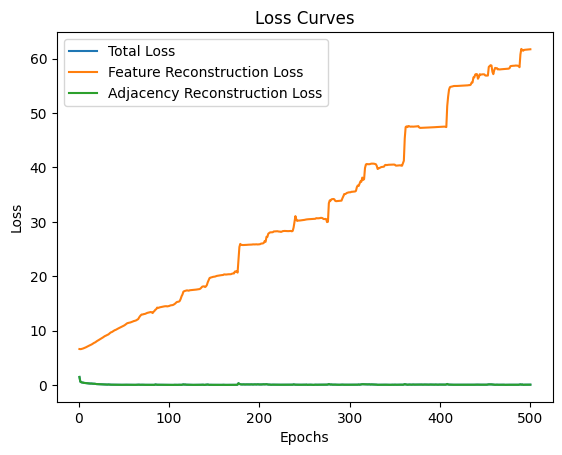

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
num_classes = len(np.unique(all_labels.cpu().numpy()))
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32
k_folds = 5

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.0):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft = torch.utils.data.DataLoader(list(zip(features_tensor, all_labels)), batch_size=batch_size_ft, shuffle=True)

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

# Lists to store losses for plotting
total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    # Record the losses for plotting
    total_loss_list.append(running_loss / len(train_loader_ft.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features = feature_transformer.encoder(features_tensor).detach().cpu().numpy()

kf = KFold(n_splits=k_folds)
accuracy_list = []
precision_list = [[] for _ in range(num_classes)]
recall_list = [[] for _ in range(num_classes)]
f1_list = [[] for _ in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

y_test_all = []
y_pred_all = []

for train_index, test_index in kf.split(new_features):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = all_labels[train_index].cpu().numpy(), all_labels[test_index].cpu().numpy()
    
    svm_classifier = SVC(probability=True)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    accuracy_list.append(accuracy)
    for i in range(num_classes):
        precision_list[i].append(report.get(str(i), {}).get('precision', 0))
        recall_list[i].append(report.get(str(i), {}).get('recall', 0))
        f1_list[i].append(report.get(str(i), {}).get('f1-score', 0))
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(np.round(conf_matrix).astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels.cpu().numpy()), yticklabels=np.unique(all_labels.cpu().numpy()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Average Accuracy: {np.mean(accuracy_list):.4f}')
for i in range(num_classes):
    print(f'Class {i} - Average Precision: {np.mean(precision_list[i]):.4f}, '
          f'Average Recall: {np.mean(recall_list[i]):.4f}, '
          f'Average F1-Score: {np.mean(f1_list[i]):.4f}')

# 绘制损失曲线
plt.figure()
plt.plot(range(1, num_epochs_ft + 1), total_loss_list, label='Total Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_loss_list, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), adj_loss_list, label='Adjacency Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# NPAE-KNN

Using device: cuda
Epoch [10/200], Loss: 0.0896
Epoch [20/200], Loss: 0.0588
Epoch [30/200], Loss: 0.0599
Epoch [40/200], Loss: 0.0585
Epoch [50/200], Loss: 0.0477
Epoch [60/200], Loss: 0.0429
Epoch [70/200], Loss: 0.0472
Epoch [80/200], Loss: 0.0438
Epoch [90/200], Loss: 0.0363
Epoch [100/200], Loss: 0.0440
Epoch [110/200], Loss: 0.0416
Epoch [120/200], Loss: 0.0516
Epoch [130/200], Loss: 0.0410
Epoch [140/200], Loss: 0.0443
Epoch [150/200], Loss: 0.0412
Epoch [160/200], Loss: 0.0359
Epoch [170/200], Loss: 0.0393
Epoch [180/200], Loss: 0.0404
Epoch [190/200], Loss: 0.0389
Epoch [200/200], Loss: 0.0360
Epoch [10/500], Loss: 0.4854, Feature Loss: 0.4854, Adj Loss: 59.8304
Epoch [20/500], Loss: 0.1149, Feature Loss: 0.1149, Adj Loss: 55.2344
Epoch [30/500], Loss: 0.0296, Feature Loss: 0.0296, Adj Loss: 52.6861
Epoch [40/500], Loss: 0.0281, Feature Loss: 0.0281, Adj Loss: 51.2372
Epoch [50/500], Loss: 0.0262, Feature Loss: 0.0262, Adj Loss: 49.0658
Epoch [60/500], Loss: 0.0285, Feature Lo

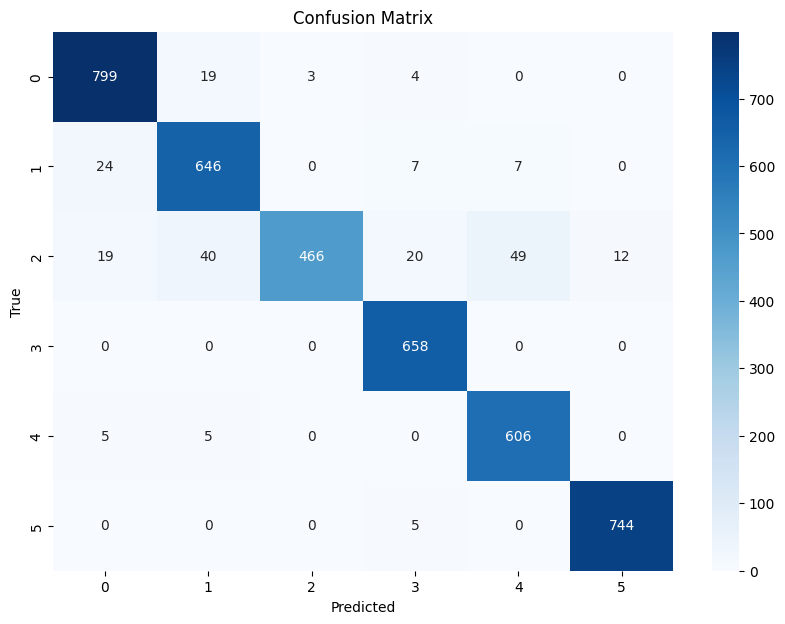

Average Accuracy: 0.9471
Class 0 - Average Precision: 0.9443, Average Recall: 0.9680, Average F1-Score: 0.9558
Class 1 - Average Precision: 0.9100, Average Recall: 0.9446, Average F1-Score: 0.9268
Class 2 - Average Precision: 0.9941, Average Recall: 0.7684, Average F1-Score: 0.8663
Class 3 - Average Precision: 0.9480, Average Recall: 1.0000, Average F1-Score: 0.9733
Class 4 - Average Precision: 0.9161, Average Recall: 0.9839, Average F1-Score: 0.9486
Class 5 - Average Precision: 0.9839, Average Recall: 0.9932, Average F1-Score: 0.9884


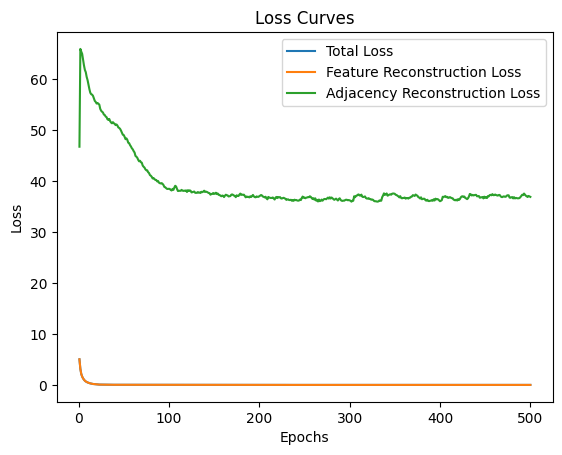

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
num_classes = len(np.unique(all_labels.cpu().numpy()))
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32
k_folds = 5

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=1.0):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft = torch.utils.data.DataLoader(list(zip(features_tensor, all_labels)), batch_size=batch_size_ft, shuffle=True)

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

# Lists to store losses for plotting
total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    # Record the losses for plotting
    total_loss_list.append(running_loss / len(train_loader_ft.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features = feature_transformer.encoder(features_tensor).detach().cpu().numpy()

kf = KFold(n_splits=k_folds)
accuracy_list = []
precision_list = [[] for _ in range(num_classes)]
recall_list = [[] for _ in range(num_classes)]
f1_list = [[] for _ in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

y_test_all = []
y_pred_all = []

for train_index, test_index in kf.split(new_features):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = all_labels[train_index].cpu().numpy(), all_labels[test_index].cpu().numpy()
    
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    accuracy_list.append(accuracy)
    for i in range(num_classes):
        precision_list[i].append(report.get(str(i), {}).get('precision', 0))
        recall_list[i].append(report.get(str(i), {}).get('recall', 0))
        f1_list[i].append(report.get(str(i), {}).get('f1-score', 0))
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(np.round(conf_matrix).astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels.cpu().numpy()), yticklabels=np.unique(all_labels.cpu().numpy()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Average Accuracy: {np.mean(accuracy_list):.4f}')
for i in range(num_classes):
    print(f'Class {i} - Average Precision: {np.mean(precision_list[i]):.4f}, '
          f'Average Recall: {np.mean(recall_list[i]):.4f}, '
          f'Average F1-Score: {np.mean(f1_list[i]):.4f}')

# 绘制损失曲线
plt.figure()
plt.plot(range(1, num_epochs_ft + 1), total_loss_list, label='Total Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_loss_list, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), adj_loss_list, label='Adjacency Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# NPAE-RF

Using device: cuda
Epoch [10/200], Loss: 0.0998
Epoch [20/200], Loss: 0.0602
Epoch [30/200], Loss: 0.0608
Epoch [40/200], Loss: 0.0579
Epoch [50/200], Loss: 0.0472
Epoch [60/200], Loss: 0.0433
Epoch [70/200], Loss: 0.0422
Epoch [80/200], Loss: 0.0479
Epoch [90/200], Loss: 0.0411
Epoch [100/200], Loss: 0.0416
Epoch [110/200], Loss: 0.0430
Epoch [120/200], Loss: 0.0418
Epoch [130/200], Loss: 0.0392
Epoch [140/200], Loss: 0.0366
Epoch [150/200], Loss: 0.0371
Epoch [160/200], Loss: 0.0336
Epoch [170/200], Loss: 0.0381
Epoch [180/200], Loss: 0.0424
Epoch [190/200], Loss: 0.0368
Epoch [200/200], Loss: 0.0467
Epoch [10/500], Loss: 0.5038, Feature Loss: 0.5038, Adj Loss: 68.7197
Epoch [20/500], Loss: 0.1457, Feature Loss: 0.1457, Adj Loss: 62.9089
Epoch [30/500], Loss: 0.0792, Feature Loss: 0.0792, Adj Loss: 59.9488
Epoch [40/500], Loss: 0.0509, Feature Loss: 0.0509, Adj Loss: 57.1577
Epoch [50/500], Loss: 0.0247, Feature Loss: 0.0247, Adj Loss: 57.1383
Epoch [60/500], Loss: 0.0024, Feature Lo

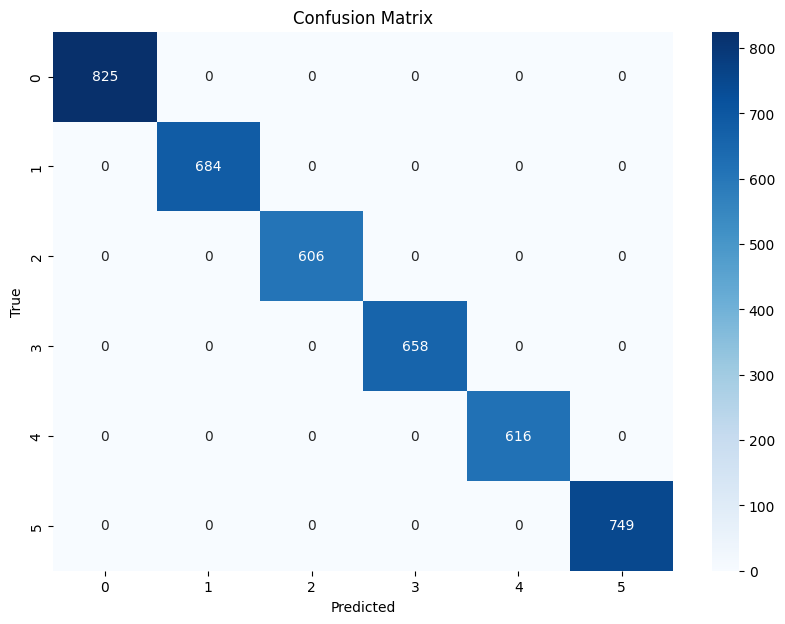

Average Accuracy: 1.0000
Class 0 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 1 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 2 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 3 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 4 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000
Class 5 - Average Precision: 1.0000, Average Recall: 1.0000, Average F1-Score: 1.0000


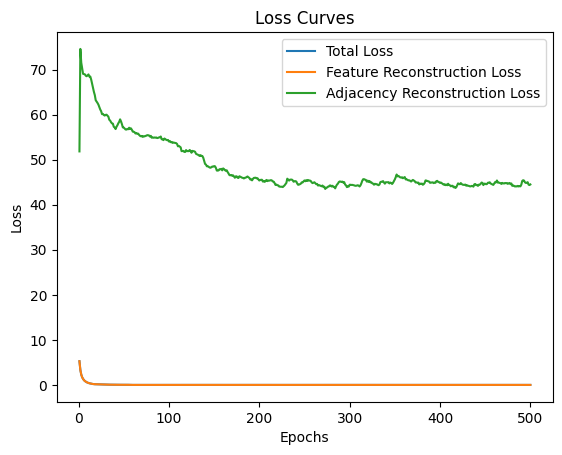

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
num_classes = len(np.unique(all_labels.cpu().numpy()))
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32
k_folds = 5

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=1.0):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft = torch.utils.data.DataLoader(list(zip(features_tensor, all_labels)), batch_size=batch_size_ft, shuffle=True)

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

# Lists to store losses for plotting
total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    # Record the losses for plotting
    total_loss_list.append(running_loss / len(train_loader_ft.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features = feature_transformer.encoder(features_tensor).detach().cpu().numpy()

kf = KFold(n_splits=k_folds)
accuracy_list = []
precision_list = [[] for _ in range(num_classes)]
recall_list = [[] for _ in range(num_classes)]
f1_list = [[] for _ in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

y_test_all = []
y_pred_all = []

for train_index, test_index in kf.split(new_features):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = all_labels[train_index].cpu().numpy(), all_labels[test_index].cpu().numpy()
    
    rf_classifier = RandomForestClassifier(n_estimators=100)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    accuracy_list.append(accuracy)
    for i in range(num_classes):
        precision_list[i].append(report.get(str(i), {}).get('precision', 0))
        recall_list[i].append(report.get(str(i), {}).get('recall', 0))
        f1_list[i].append(report.get(str(i), {}).get('f1-score', 0))
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(np.round(conf_matrix).astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels.cpu().numpy()), yticklabels=np.unique(all_labels.cpu().numpy()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Average Accuracy: {np.mean(accuracy_list):.4f}')
for i in range(num_classes):
    print(f'Class {i} - Average Precision: {np.mean(precision_list[i]):.4f}, '
          f'Average Recall: {np.mean(recall_list[i]):.4f}, '
          f'Average F1-Score: {np.mean(f1_list[i]):.4f}')

# 绘制损失曲线
plt.figure()
plt.plot(range(1, num_epochs_ft + 1), total_loss_list, label='Total Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_loss_list, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), adj_loss_list, label='Adjacency Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# NPAE-GMM Clustering

Using device: cuda
Epoch [10/200], Loss: 0.0930
Epoch [20/200], Loss: 0.0662
Epoch [30/200], Loss: 0.0499
Epoch [40/200], Loss: 0.0638
Epoch [50/200], Loss: 0.0422
Epoch [60/200], Loss: 0.0434
Epoch [70/200], Loss: 0.0412
Epoch [80/200], Loss: 0.0456
Epoch [90/200], Loss: 0.0449
Epoch [100/200], Loss: 0.0398
Epoch [110/200], Loss: 0.0376
Epoch [120/200], Loss: 0.0396
Epoch [130/200], Loss: 0.0374
Epoch [140/200], Loss: 0.0415
Epoch [150/200], Loss: 0.0380
Epoch [160/200], Loss: 0.0411
Epoch [170/200], Loss: 0.0396
Epoch [180/200], Loss: 0.0425
Epoch [190/200], Loss: 0.0360
Epoch [200/200], Loss: 0.0352
Epoch [10/500], Loss: 0.3712, Feature Loss: 0.5535, Adj Loss: 0.1890
Epoch [20/500], Loss: 0.1812, Feature Loss: 0.3168, Adj Loss: 0.0456
Epoch [30/500], Loss: 0.1238, Feature Loss: 0.2264, Adj Loss: 0.0211
Epoch [40/500], Loss: 0.0975, Feature Loss: 0.1803, Adj Loss: 0.0147
Epoch [50/500], Loss: 0.0905, Feature Loss: 0.1553, Adj Loss: 0.0256
Epoch [60/500], Loss: 0.0698, Feature Loss: 0

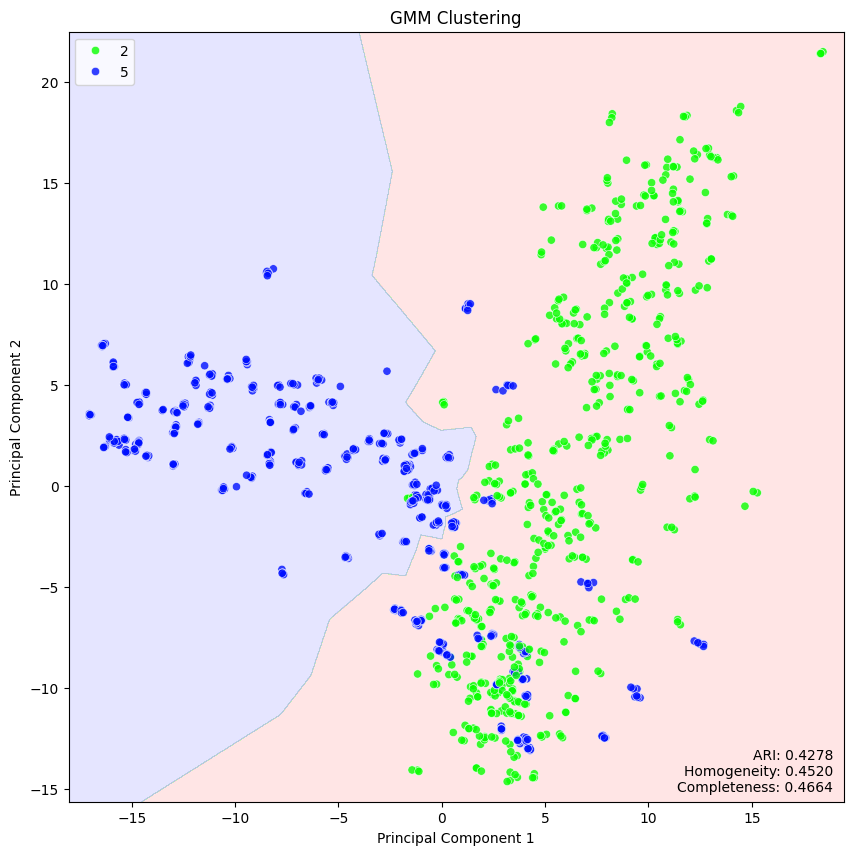

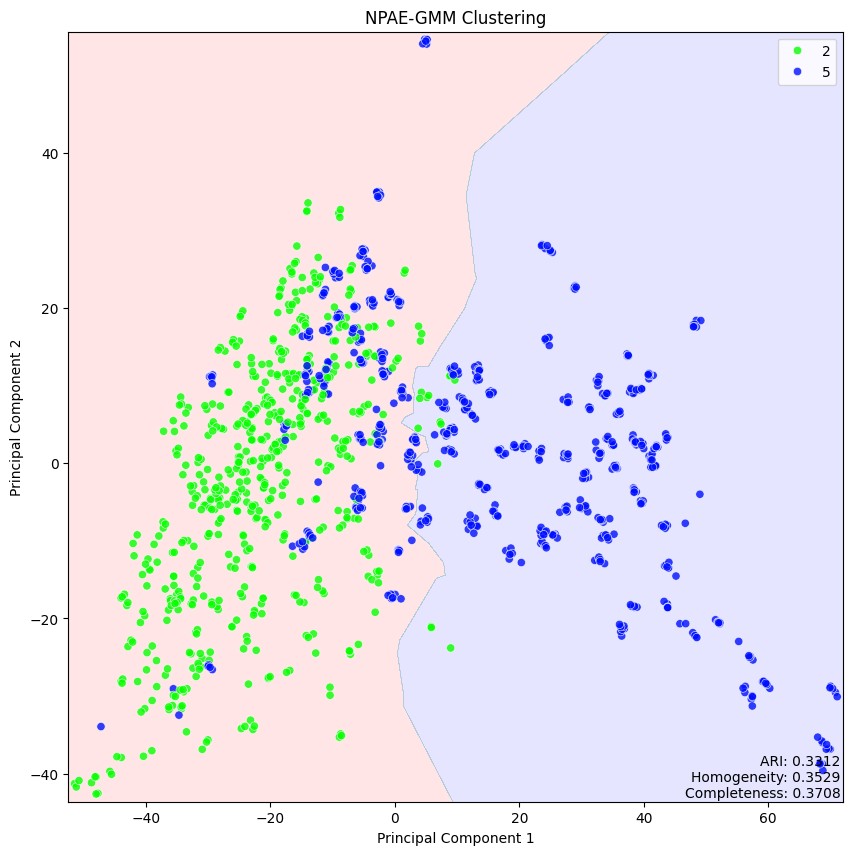

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

group1_labels = [0, 1, 3, 4]
group2_labels = [2, 5]

group1_indices = [i for i, label in enumerate(all_labels.cpu().numpy()) if label in group1_labels]
group2_indices = [i for i, label in enumerate(all_labels.cpu().numpy()) if label in group2_labels]

group1_features = all_features[group1_indices]
group1_labels_tensor = all_labels[group1_indices]

group2_features = all_features[group2_indices]
group2_labels_tensor = all_labels[group2_indices]

group1_features_tensor = torch.tensor(group1_features, dtype=torch.float32).to(device)
group2_features_tensor = torch.tensor(group2_features, dtype=torch.float32).to(device)

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return torch.tensor(adj_matrix, dtype=torch.float32).to(device)

num_epochs_ft = 500
batch_size_ft = 64

train_loader_ft_group1 = torch.utils.data.DataLoader(list(zip(group1_features_tensor, group1_labels_tensor)), batch_size=batch_size_ft, shuffle=True)

total_loss_list = []
feature_loss_list = []
adj_loss_list = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_loss = 0.0
    running_feature_loss = 0.0
    running_adj_loss = 0.0
    
    for data, labels in train_loader_ft_group1:
        optimizer_ft.zero_grad()
        adj_tensor = create_adj_matrix(labels.cpu().numpy())
        z, x_reconstructed, adj_pred = feature_transformer(data)
        loss, feature_loss, adj_loss = joint_loss_function(data, x_reconstructed, adj_tensor, adj_pred)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item() * data.size(0)
        running_feature_loss += feature_loss.item() * data.size(0)
        running_adj_loss += adj_loss.item() * data.size(0)

    total_loss_list.append(running_loss / len(train_loader_ft_group1.dataset))
    feature_loss_list.append(running_feature_loss / len(train_loader_ft_group1.dataset))
    adj_loss_list.append(running_adj_loss / len(train_loader_ft_group1.dataset))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Loss: {running_loss / len(train_loader_ft_group1.dataset):.4f}, '
              f'Feature Loss: {running_feature_loss / len(train_loader_ft_group1.dataset):.4f}, '
              f'Adj Loss: {running_adj_loss / len(train_loader_ft_group1.dataset):.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

new_features_group1 = feature_transformer.encoder(group1_features_tensor).detach().cpu().numpy()
new_features_group2 = feature_transformer.encoder(group2_features_tensor).detach().cpu().numpy()

def plot_features_with_boundaries(reduced_features, labels, title, ari, homogeneity, completeness, cluster_labels):
    h = .02
    x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
    y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = np.array([cluster_labels[distance.cdist([p], reduced_features).argmin()] for p in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette=sns.color_palette("hsv", len(np.unique(labels))), alpha=0.8)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.text(x_max - 0.5, y_min + 0.5, f'ARI: {ari:.4f}\nHomogeneity: {homogeneity:.4f}\nCompleteness: {completeness:.4f}', horizontalalignment='right')
    plt.show()

def evaluate_clustering(true_labels, features, n_clusters):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features.astype(np.float64))  # 转换为 float64
    gmm = GaussianMixture(n_components=n_clusters)
    cluster_labels = gmm.fit_predict(reduced_features.astype(np.float64))  # 转换为 float64
    
    print(f"评估实际迭代次数: {gmm.n_iter_}")
    
    ari = adjusted_rand_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    return ari, homogeneity, completeness, cluster_labels, reduced_features

ari_original, homogeneity_original, completeness_original, cluster_labels_original, reduced_features_original = evaluate_clustering(group2_labels_tensor.cpu().numpy(), group2_features, len(np.unique(group2_labels_tensor.cpu().numpy())))
ari_transformed, homogeneity_transformed, completeness_transformed, cluster_labels_transformed, reduced_features_transformed = evaluate_clustering(group2_labels_tensor.cpu().numpy(), new_features_group2, len(np.unique(group2_labels_tensor.cpu().numpy())))

plot_features_with_boundaries(reduced_features_original, group2_labels_tensor.cpu().numpy(), 'GMM Clustering', ari_original, homogeneity_original, completeness_original, cluster_labels_original)
plot_features_with_boundaries(reduced_features_transformed, group2_labels_tensor.cpu().numpy(), 'NPAE-GMM Clustering', ari_transformed, homogeneity_transformed, completeness_transformed, cluster_labels_transformed)
